In [26]:
import vitaldb
import numpy as np
import pandas as pd
import scipy.signal as ss
from scipy.ndimage import minimum_filter1d, maximum_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.auto import tqdm

# colorblind friendly palette
import matplotlib as mpl
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']
plt.rcParams['figure.figsize'] = [10, 5]

In [27]:
def createWindows(win_len, fs, N_samp, overlap):
    win_len = win_len * fs
    overlap = np.round(overlap * win_len)
    N_samp = N_samp - win_len + 1
    
    idx_start = np.round(np.arange(0, N_samp, win_len - overlap)).astype(int)
    idx_stop = np.round(idx_start + win_len - 1).astype(int)
    
    return idx_start, idx_stop

In [28]:
def um(ta=None, tb=None, data=[[], [], []], t=[]):
    ta = ta if ta else t.min()
    tb = tb if tb else t.max()
    twin = (t >= ta) & (t <= tb)

    plt.figure(figsize=(12,8), dpi=100)
    for i, sig in enumerate(data):
        sig = np.ma.masked_invalid(sig)
        plt.subplot(3,1,i+1)
        plt.plot(t[twin], sig[twin], lw=1, c=cp[i])
        sns.despine(bottom=i<2)
        if i<2: plt.xticks([])
        plt.xlim(ta, tb)
        plt.tight_layout()
        plt.show()

In [29]:
def processor_phase1(ppg=[], fs=500, window_size_mult = 10, art = True):
    
    window_size = int(window_size_mult*fs)
    
    ymin = minimum_filter1d(ppg, window_size)
    ymax = maximum_filter1d(ppg, window_size)

    ppgpeaks, _ = ss.find_peaks(ppg,
                                height=(ymax+ymin)/2,
                                prominence=(ymax-ymin)*0.3,
                                distance=fs/3)

    #blood pressure should be reasonable
    if art:
        valid = (ymin > 20) & (ymax < 300)

    #Get the valid peaks here
    yminp, ymaxp = ymin[ppgpeaks], ymax[ppgpeaks]
    ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
    ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
    valid[ppgpeaks[ymindiff > 0.5]] = False
    valid[ppgpeaks[ymaxdiff > 0.5]] = False

    # Calculate the heart rate from r values
    rri = np.diff(ppgpeaks, prepend=0) / fs
    hr = 60/rri
    rriv = np.abs(np.diff(rri, append=0)) / rri

    # Reasonable heartrate check
    valid[ppgpeaks[hr < 30]] = False
    valid[ppgpeaks[rriv > 0.4]] = False
    
    #return the bit mask 
    return valid    

In [30]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

In [31]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/ECG_II']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/PLETH']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
    set(df_cases[df_cases['weight'] < 140]['caseid']) & 
    set(df_cases[df_cases['height'] >= 135]['caseid']) & 
    set(df_cases[df_cases['height'] < 200]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))

Total 3235 cases found


04/28/2023, 15:11:30: Processing subject 1 of 3235
529854


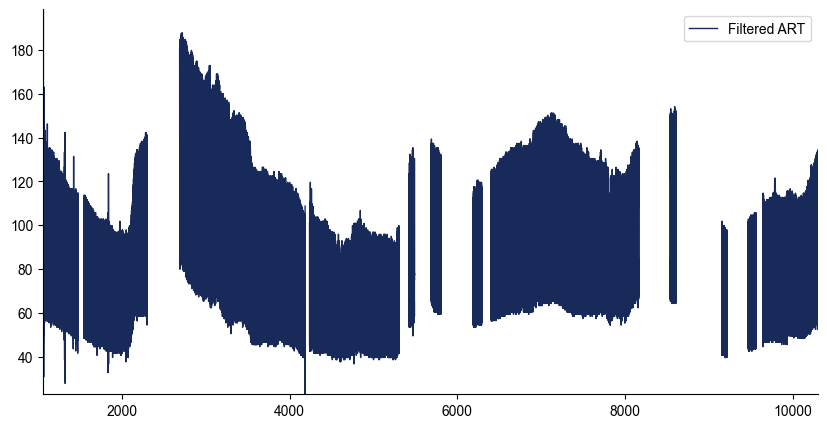

529854


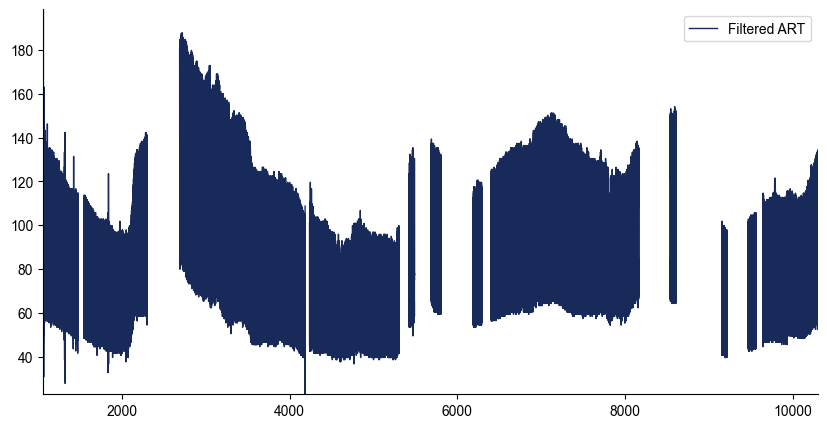

529854


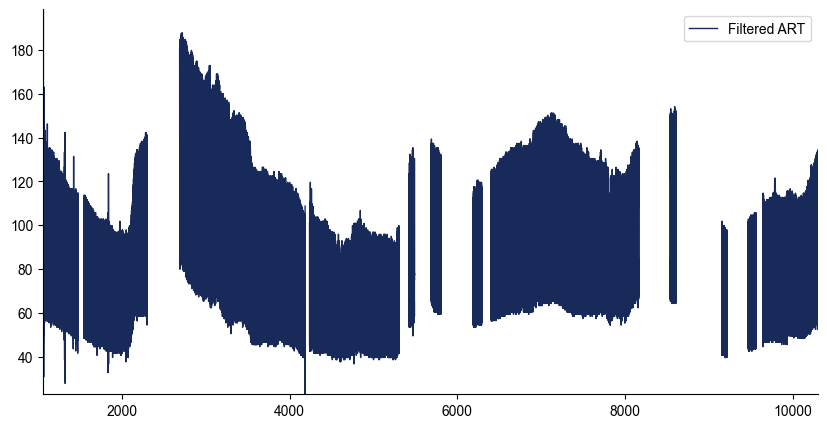

529854


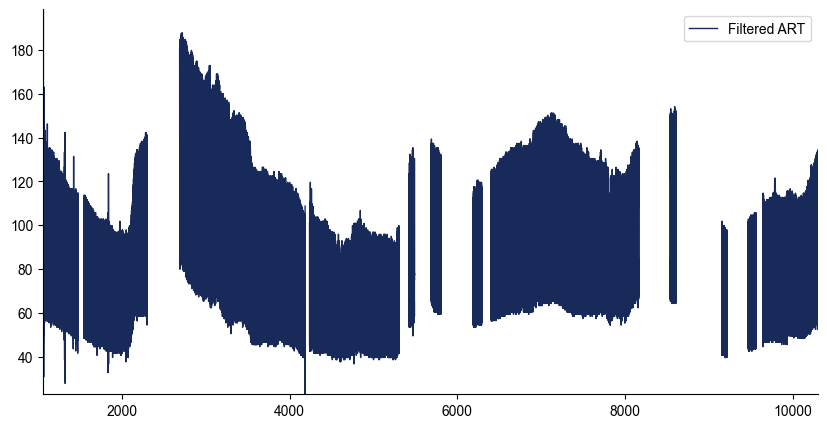

529854


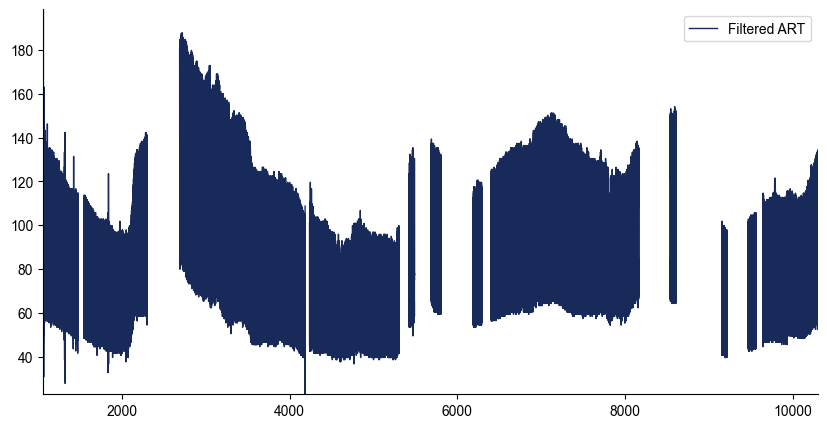

529854


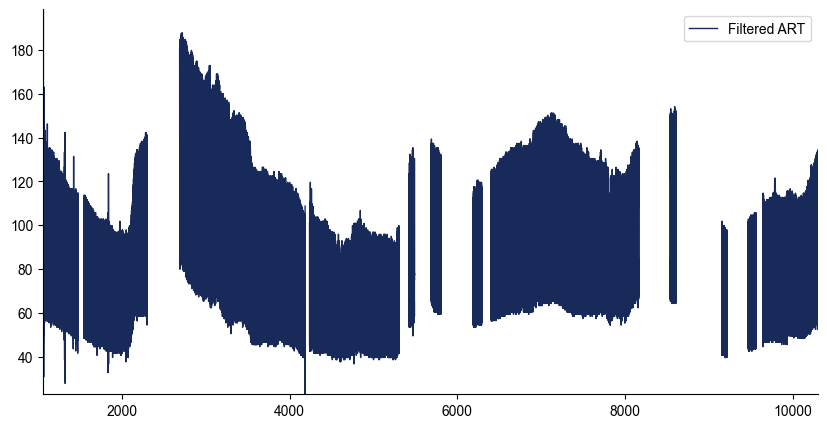

529854


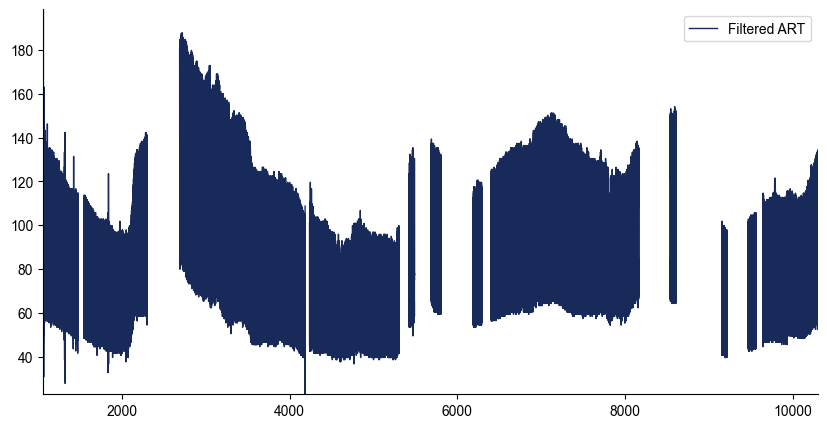

529854


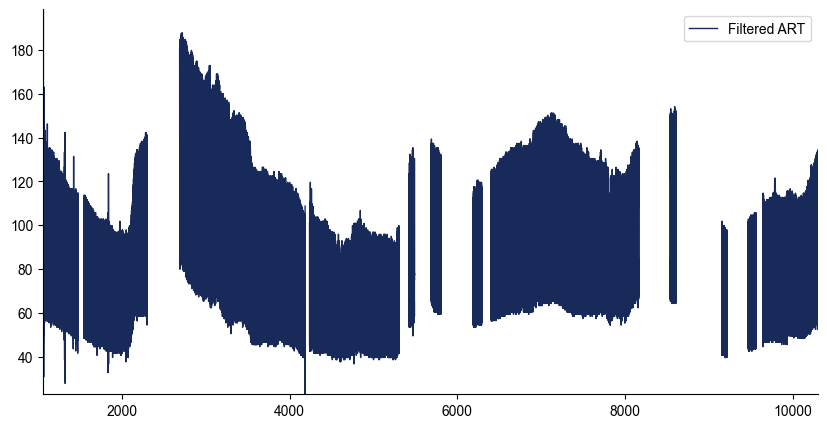

529854


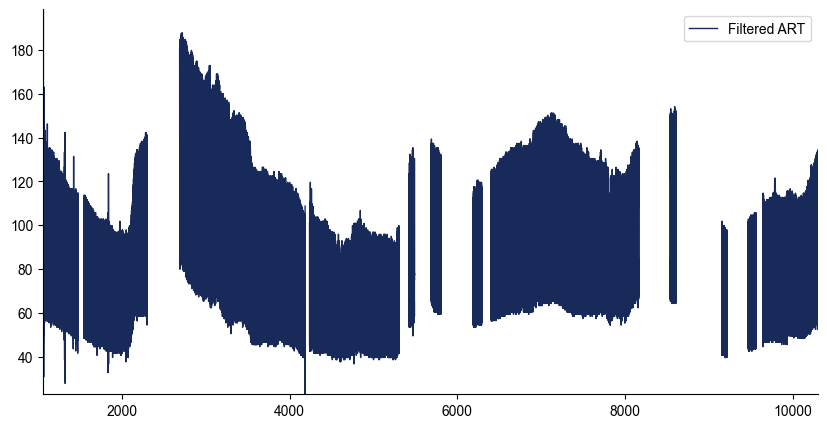

529854


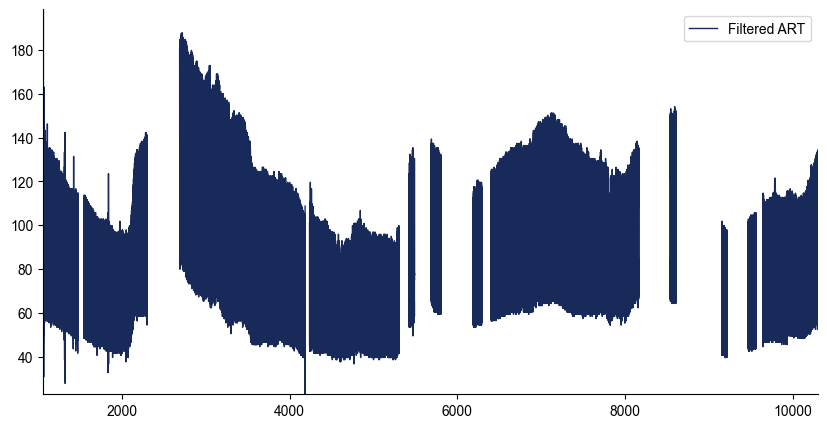

529854


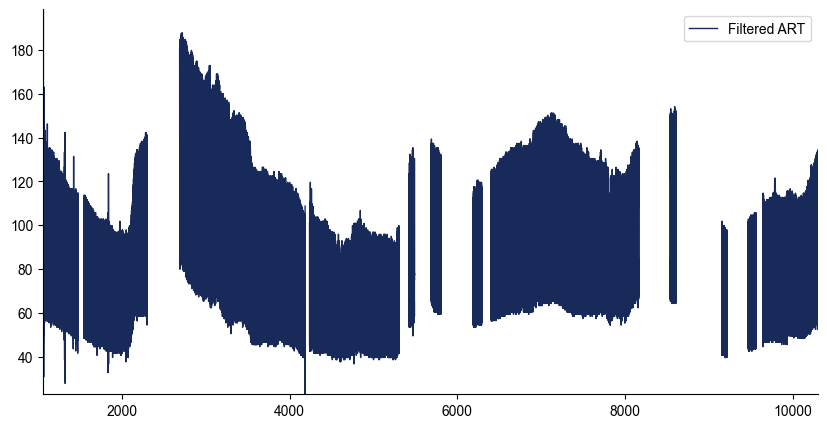

529854


KeyboardInterrupt: 

In [24]:
plots_on = False
debug_on = True
standard_processing = True

MAX_LENGTH = 10
win_len = 100
fs = 125

PPG_RECORD = np.empty((0, int(win_len*fs)))
ECG_RECORD = np.empty((0, int(win_len*fs)))
ART_RECORD = np.empty((0, int(win_len*fs)))    

for id in range(MAX_LENGTH):
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing subject {id + 1} of {len(caseids)}',end='\n')
    
    track_names = ['ECG_II', 'ART', 'PLETH']
    vf = vitaldb.VitalFile(caseids[id], track_names) 
    data = vf.to_numpy(track_names, 1/fs)
    t = np.arange(data.shape[0]) / fs
    
    ecg, art, ppg = data[:, 0], data[:, 1], data[:, 2]
    
    #if plots_on:
    #    um(60*30, 60*31, [ecg, art, ppg], np.arange(len(ecg)/fs))
        
    N_samples = ecg.shape[0]
    win_start, win_stop = createWindows(win_len, fs, N_samples, 0)
    N_win = len(win_start)
    #N_samp_total += N_win
    
    #Parkers processing method
    if  ~standard_processing:
        ppg_mask = processor_phase1(ppg)
        art_mask = processor_phase1(art)
        
        valid = ppg_mask & art_mask
    
        labels = np.cumsum(np.diff(valid, prepend=False))
        counts = np.bincount(labels)[labels]
        mask = valid & (counts > fs*61)                     #fs*61 is in the window length --> 61 second windows

        artm, ppgm = art.copy(), ppg.copy()
        artm[~mask] = np.nan
        ppgm[~mask] = np.nan
        
        #print(f'Num NaNs in Valid: {len(mask) - np.sum(mask)}. Num Nans in signal = {np.count_nonzero(np.isnan(artm))}', end ='\n')
        
        if plots_on:
            plt.figure(figsize=(8,4))
            plt.subplot(3,1,1)
            plt.plot(t, art, lw=1, label = "Original ART")
            #plt.xlim([0, len(ppg)])
            sns.despine()
            plt.gca().margins(0)
            plt.legend()

            plt.subplot(3,1,2)
            plt.plot(t, artm, lw=1, label = "Filtered ART")
            #plt.xlim([0, len(ppg)])
            sns.despine()
            plt.gca().margins(0)
            plt.legend()
            plt.show()
             
    # Start the extraction process here
    # filtered ppg = ppgm
    # filtered art = artm
    # both are the same length and have the same NaN regions
    # fs = 125  
    
    # Goals:
    # Extract continuous non NaN segments form the PPG and ART signals
        
    
    

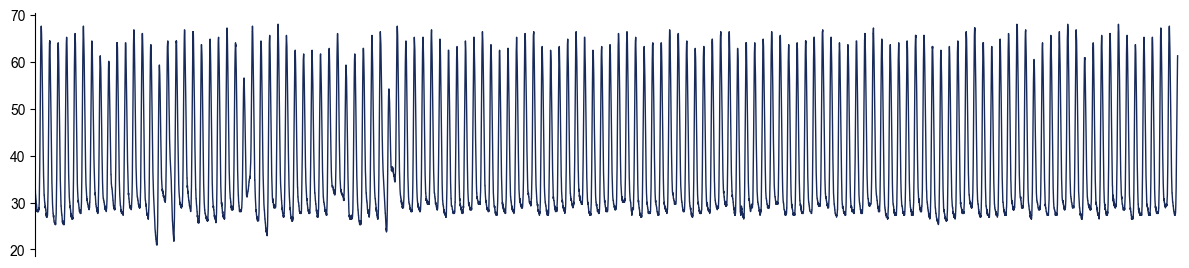

In [44]:
um(data=[PPG_RECORD[100, :]], t=np.arange(PPG_RECORD.shape[1])/fs)

In [25]:
ppg = PPG_RECORD[10, :]

In [24]:
if np.any(np.isnan(test_data)):
    print("Nan found")
    test_data = np.nan_to_num(test_data, nan=0.0, posinf=None, neginf=None)

else:
    print("No Nan found")

No Nan found


In [31]:
ymin = minimum_filter1d(ppg, int(fs*10))
ymax = maximum_filter1d(ppg, int(fs*10))

ppgpeaks, _ = ss.find_peaks(ppg,
                            height=(ymax+ymin)/2,
                            prominence=(ymax-ymin)*0.3,
                            distance=fs/3)

valid = (ymin > 20) & (ymax < 300)

yminp, ymaxp = ymin[ppgpeaks], ymax[ppgpeaks]
ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
valid[ppgpeaks[ymindiff > 0.3]] = False
valid[ppgpeaks[ymaxdiff > 0.3]] = False

rri = np.diff(ppgpeaks, prepend=0) / fs
hr = 60/rri
rriv = np.abs(np.diff(rri, append=0)) / rri

valid[ppgpeaks[hr < 30]] = False
valid[ppgpeaks[rriv > 0.4]] = False

labels = np.cumsum(np.diff(valid, prepend=False))
counts = np.bincount(labels)[labels]
mask = valid & (counts > fs*61)

ppgm = ppg.copy()
ppgm[~mask] = np.nan

# find the number of nans in ppgm
print(np.isnan(ppgm).sum())


82


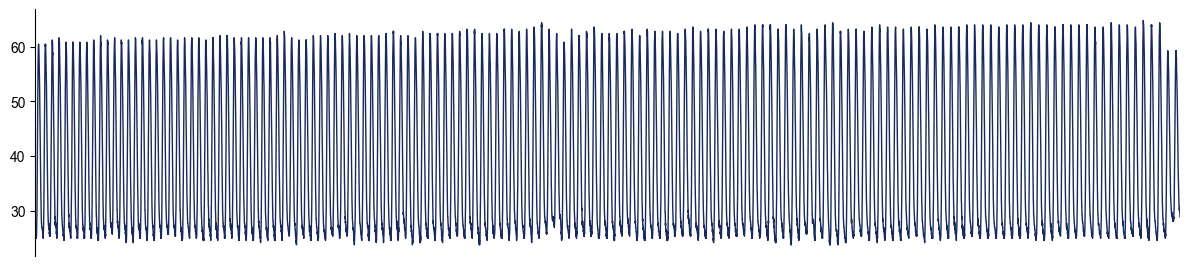

In [30]:
um(data=[PPG_RECORD[10, :]], t=np.arange(PPG_RECORD.shape[1])/fs)

82


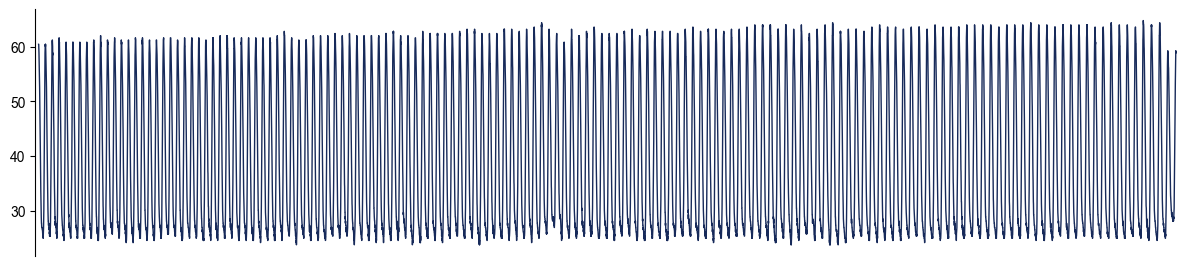

In [34]:
um(data=[check_heart_rate(ppg, 125)], t=np.arange(PPG_RECORD.shape[1])/fs)

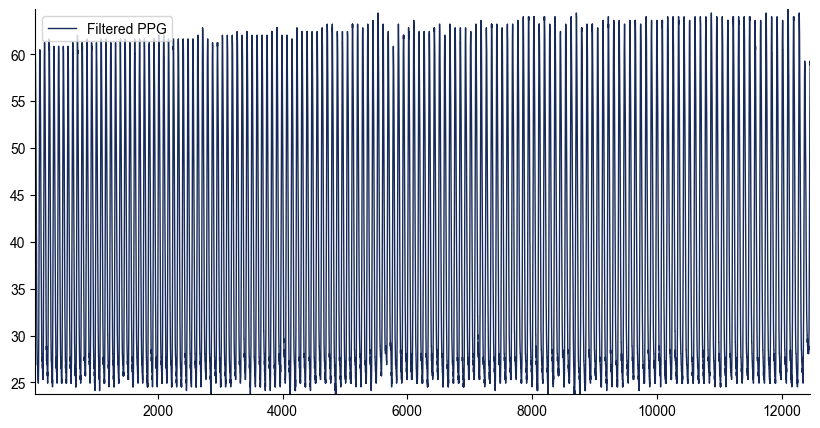

In [28]:
plt.plot(ppgm, lw=1, label = "Filtered PPG")
#plt.plot(t, artm, lw=1, label = "Filtered")
sns.despine()
plt.gca().margins(0)
plt.legend()